In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the dataset
train_data = pd.read_csv('ObesityTrain2.csv')

# Encode categorical features
label_encoders = {}
for column in train_data.select_dtypes(include=['object']).columns:
    if column != 'ObStatus':  # Exclude target column
        le = LabelEncoder()
        train_data[column] = le.fit_transform(train_data[column].astype(str))
        label_encoders[column] = le

# Encode the target variable
target_encoder = LabelEncoder()
train_data['ObStatus'] = target_encoder.fit_transform(train_data['ObStatus'])

# Scale numeric columns to the range [0, 1]
numeric_columns = train_data.select_dtypes(include=['float64', 'int64']).columns
scaler = MinMaxScaler()
train_data[numeric_columns] = scaler.fit_transform(train_data[numeric_columns])

# Ensure the full head is displayed without truncation
pd.set_option('display.max_columns', None)  # Show all columns
train_data.head()  # Print the first 5 rows

,Age,Gender,Height,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,Race,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,HeartDisease,hypertension,ever_married,work_type,Residence_type,avg_glucose_level,stroke,ObStatus
0,0.234043,0,0.207547,1,2,0.5,0.666667,2,1,0.000000,1,0.000000,0.000000,2,3,3,0.51,0.417910,2,2,0.819549,1,0,0,0,2,0,0.316090,0,0
1,0.255319,0,0.284726,0,2,1.0,0.666667,2,1,0.777594,1,0.000000,0.231487,2,3,2,0.65,0.000000,0,3,0.556391,0,1,0,0,3,1,0.719968,0,1
2,0.255319,0,0.347066,2,2,1.0,0.666667,2,1,0.841402,0,0.000000,0.075855,2,3,1,0.65,NaN,0,1,0.872180,1,0,2,0,2,1,0.305327,0,1
3,0.106383,1,NaN,1,2,NaN,0.666667,1,1,0.000000,1,0.333333,0.500000,2,3,3,0.50,0.303483,0,1,0.819549,0,0,0,0,2,0,0.057435,0,0
4,0.191489,1,0.584906,1,2,1.0,0.666667,2,1,0.000000,1,0.000000,0.000000,3,3,3,0.65,0.396352,2,2,0.759398,1,2,0,0,2,1,0.344113,0,0


In [3]:
# Handle missing values
imputer = SimpleImputer(strategy='median')
train_data_imputed = pd.DataFrame(imputer.fit_transform(train_data), columns=train_data.columns)

# Separate features and target
X = train_data_imputed.drop(columns=['ObStatus'])
y = train_data_imputed['ObStatus']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [4]:
# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [6, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'subsample': [0.6, 0.8, 1.0]
}

# Initialize the XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Perform GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_train_balanced, y_train_balanced)

# Get the best parameters and best model
xgb_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model Accuracy with GridSearch: {accuracy:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\nadee_4wl0sna\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [14:22:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 300, 'subsample': 1.0}
XGBoost Model Accuracy with GridSearch: 0.9941


In [5]:
# Classification report
print("\nClassification Report (Full XGBoost Model):")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))


Classification Report (Full XGBoost Model):
              precision    recall  f1-score   support

   Not Obese       0.99      1.00      1.00      5902
       Obese       1.00      0.99      0.99      3703

    accuracy                           0.99      9605
   macro avg       0.99      0.99      0.99      9605
weighted avg       0.99      0.99      0.99      9605



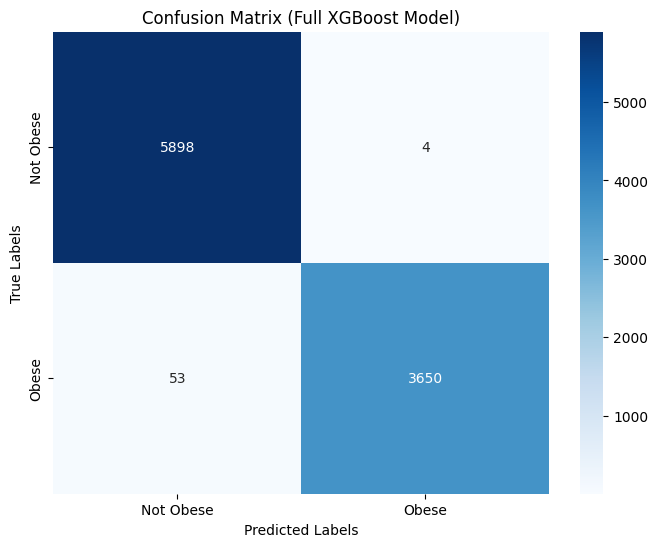

In [6]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Full XGBoost Model)")
plt.show()

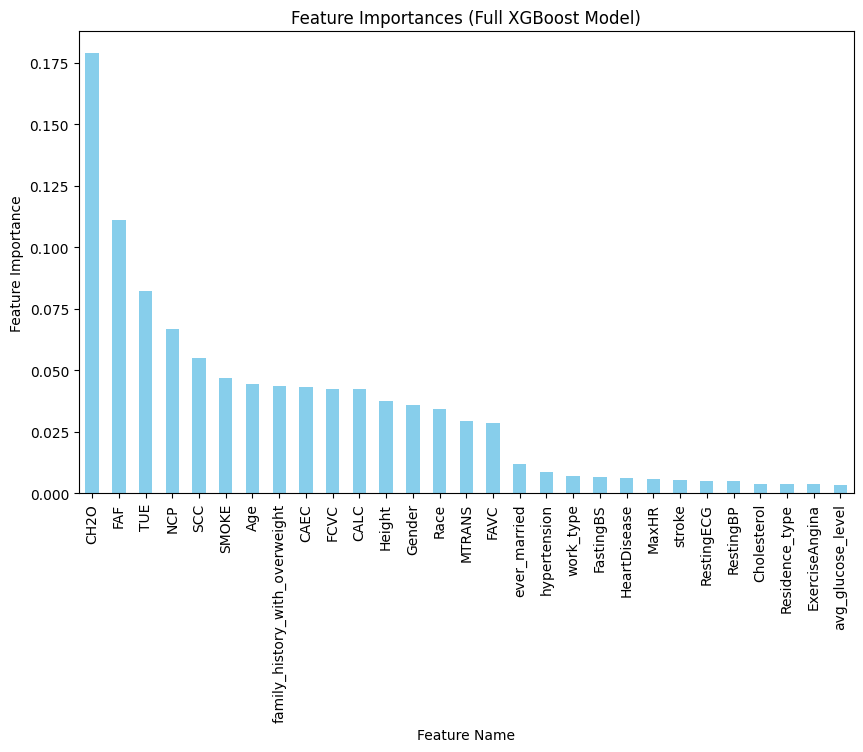

In [7]:
# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar', color='skyblue')
plt.title("Feature Importances (Full XGBoost Model)")
plt.ylabel("Feature Importance")
plt.xlabel("Feature Name")
plt.show()

In [8]:
# Set the threshold for feature selection dynamically
feature_selection_threshold = 0.02  # Change this value to adjust the threshold

# Filter features dynamically based on importance
selected_features = feature_importance[feature_importance >= feature_selection_threshold].index.tolist()
print(f"Selected features based on threshold {feature_selection_threshold}: {selected_features}")

# Prepare the data with selected features
X = train_data_imputed[selected_features]
y = train_data_imputed['ObStatus']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Selected features based on threshold 0.02: ['CH2O', 'FAF', 'TUE', 'NCP', 'SCC', 'SMOKE', 'Age', 'family_history_with_overweight', 'CAEC', 'FCVC', 'CALC', 'Height', 'Gender', 'Race', 'MTRANS', 'FAVC']


In [9]:
# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Initialize XGBoost model with the given hyperparameters
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=15,
    learning_rate=0.1,
    colsample_bytree=0.6,
    subsample=1.0,
    random_state=42
)

# Train the model
xgb_model.fit(X_train_balanced, y_train_balanced)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [10]:
# Evaluate the model on the test set
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Model w/ Feature Selection Accuracy: {accuracy:.4f}")

XGBoost Model w/ Feature Selection Accuracy: 0.9968


In [11]:
# Classification report
print("\nClassification Report (XGBoost Model w/ Feature Selection):")
print(classification_report(y_test, y_pred, target_names=target_encoder.classes_))


Classification Report (XGBoost Model w/ Feature Selection):
              precision    recall  f1-score   support

   Not Obese       1.00      1.00      1.00      5902
       Obese       1.00      0.99      1.00      3703

    accuracy                           1.00      9605
   macro avg       1.00      1.00      1.00      9605
weighted avg       1.00      1.00      1.00      9605



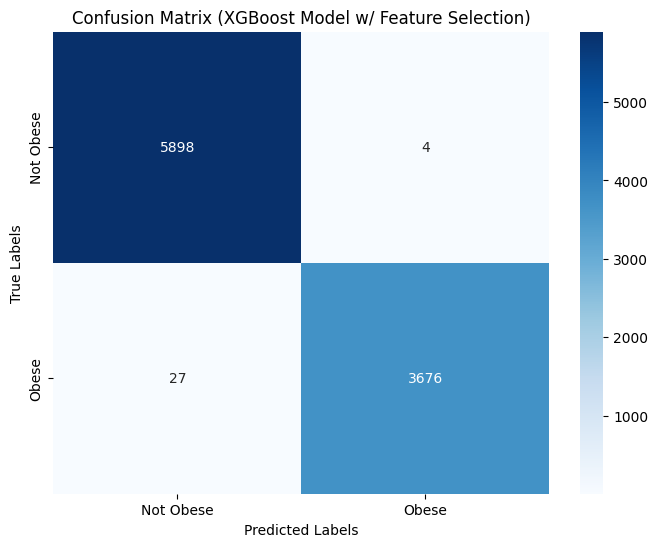

In [12]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (XGBoost Model w/ Feature Selection)")
plt.show()

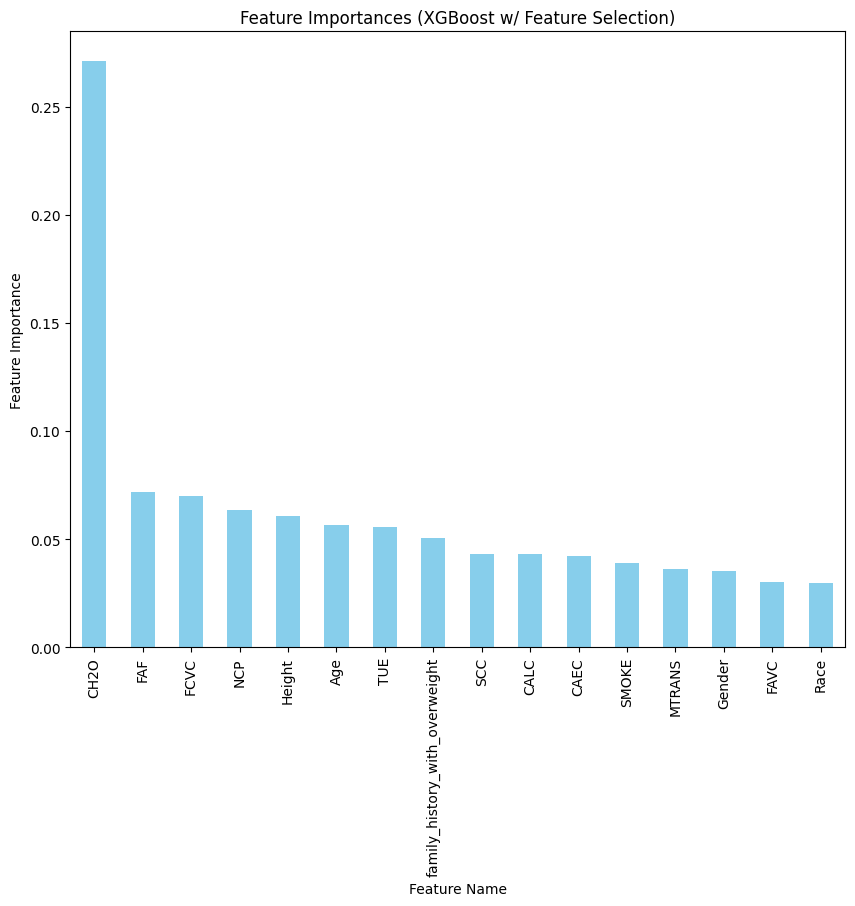

In [13]:
# Feature importance
plt.figure(figsize=(10, 8))
feature_importance = pd.Series(xgb_model.feature_importances_, index=selected_features).sort_values(ascending=False)

feature_importance.plot(kind='bar', color='skyblue')
plt.title("Feature Importances (XGBoost w/ Feature Selection)")
plt.ylabel("Feature Importance")
plt.xlabel("Feature Name")
plt.show()

In [14]:
# Load the testing data
test_data = pd.read_csv('ObesityTestNoY2.csv')

test_data['ObStatus'] = 0

# Apply preprocessing to the testing data
# Encode categorical features
for column, le in label_encoders.items():
    if column in test_data.columns:  # Ensure the column exists in test data
        test_data[column] = le.transform(test_data[column].astype(str))

# Scale numeric columns to the range [0, 1]
test_data[numeric_columns] = scaler.transform(test_data[numeric_columns])

# Handle missing values
test_data_imputed = pd.DataFrame(imputer.transform(test_data), columns=test_data.columns)

# Select features based on importance
X_test_final = test_data_imputed[selected_features]

# Predict the labels for the testing data
test_predictions = xgb_model.predict(X_test_final)

# Decode predictions back to original labels
decoded_predictions = target_encoder.inverse_transform(test_predictions)

# Save predictions to a CSV file
output = pd.DataFrame({'ObStatus': decoded_predictions})
output = pd.DataFrame({'ID': test_data.index + 1, 'ObStatus': decoded_predictions})
output.to_csv('ObesityTestPredictions.csv', index=False)

print("Predictions saved to 'ObesityTestPredictions.csv'")

output.head()

Predictions saved to 'ObesityTestPredictions.csv'


,ID,ObStatus
0,1,Not Obese
1,2,Not Obese
2,3,Not Obese
3,4,Not Obese
4,5,Not Obese
